# Illustration of Fisher's combination method

We'll set up a hypothetical election and a single sample of ballots to illustrate how to combine a ballot-polling audit with a ballot-comparison audit using Fisher's combining function.

There are two strata. One contains every CVR county and the other contains every no-CVR county.
There were 11,000 ballots cast in the election, 10,000 in the CVR stratum and 1,000 in the no-CVR stratum.

In the CVR stratum, there were 4,550 votes reported for A, 4,950 votes for candidate B, and 500 invalid ballots.
In the no-CVR stratum, there were 750 votes reported for A, 150 votes for B, and 100 invalid ballots.
A won overall, with 5,300 votes to B's 5,1000, but not in the CVR stratum.
The reported vote margin between A and B is 200 votes, a "diluted margin" of $200/11,000 = 1.8\%$.


Candidate | Stratum 1 | Stratum 2 | total 
---|---|---|---
A | 4,550 | 750 | 5,300
B | 4,950 | 150 | 5,100
Ballots | 10,000 | 1,000 | 11,000
Diluted margin | -4% | 60% | 1.8%

We want to limit the risk of certifying an incorrect outcome to at most $\alpha=10\%$. 

In the CVR stratum, we sample 500 ballots and find no discrepancies.

In the no-CVR stratum, we sample 250 ballots. We are unusually lucky and the vote proportions in the sample match those in the population. There are $187$ ballots for A and $37$ ballots for B. 

In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import scipy.optimize
from ballot_comparison import ballot_comparison_pvalue
from hypergeometric import trihypergeometric_optim
from fishers_combination import fisher_combined_pvalue, maximize_fisher_combined_pvalue, \
     bound_fisher_fun, calculate_lambda_range

    
from sprt import ballot_polling_sprt

import matplotlib.pyplot as plt
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
N1 = 10000
N2 = 1000
N_w1 = 4550
N_l1 = 4950
N_w2 = 750
N_l2= 150
margin = (N_w1 + N_w2 - N_l1 - N_l2)

n1 = 500
n2 = 250

Below, we define functions for computing $P$-values based on the observed samples. 
The observed statistics and known parameters (e.g. the total number of ballots cast in each stratum) should be plugged in already. These $P$-values are functions of the error allocation $\lambda$ which determines how much overstatement error is allowed in each stratum.

In [3]:
cvr_pvalue = lambda alloc: \
    ballot_comparison_pvalue(n=n1, gamma=1.03905, o1=0, u1=0, o2=0, u2=0, \
                             reported_margin=margin, N=N1, null_lambda=alloc)
#nocvr_pvalue = lambda alloc: \
#    trihypergeometric_optim(sample= np.array([0]*int(n2*N_l2/N2)+\
#                                             [1]*int(n2*N_w2/N2)+\
#                                             [np.nan]*int(n2*(N2-N_l2-N_w2)/N2 + 1)), \
#                            popsize=N2, \
#                            null_margin=(N_w2-N_l2) - alloc*margin)
    
nocvr_pvalue = lambda alloc: \
    ballot_polling_sprt(sample= np.array([0]*int(n2*N_l2/N2)+\
                                             [1]*int(n2*N_w2/N2)+\
                                             [np.nan]*int(n2*(N2-N_l2-N_w2)/N2 + 1)), \
                            popsize=N2, \
                            alpha=0.05,  # set this param but we don't need to use it
                            Vw=N_w2, \
                            Vl=N_l2, \
                            null_margin=(N_w2-N_l2) - alloc*margin)['pvalue']

In [4]:
# This is one possible allocation lambda=0.3

print("lambda = 0.3")
pvalues = [cvr_pvalue(0.3), nocvr_pvalue(0.7)]
print("CVR P-value:", pvalues[0], "\nno-CVR P-value:", pvalues[1])
fisher_pvalue = fisher_combined_pvalue(pvalues)
print("Fisher's combined P-value:", fisher_pvalue)

lambda = 0.3
CVR P-value: 0.23557770396261943 
no-CVR P-value: 0.00606813850408649
Fisher's combined P-value: 0.010793459265074135


# Maximizing the $P$-value over $\lambda$

We can stop the audit if the $P$-value is less than the risk limit, $10\%$, for all values of $\lambda$ that allocating the overstatement error between the CVR and no-CVR strata. First, let's just plot the $P$-values in each stratum for varying values of $\lambda$ to see how they behave.

Lambda limits: -7 4


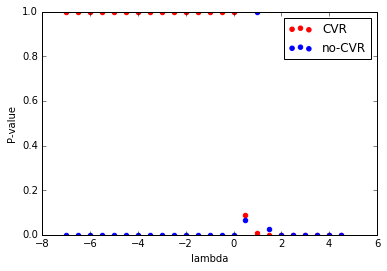

In [5]:
# find range of possible lambda
lambda_upper = int(np.min([2*N1/margin, 1+2*N2/margin, 1 + (N2-N_w2+N_l2)/margin]))+1
lambda_lower = int(np.max([-2*N1/margin, 1-2*N2/margin, 1 - (N2+N_w2-N_l2)/margin]))

#(lambda_lower, lambda_upper) = calculate_lambda_range(N_w1, N_l1, N1, N_w2, N_l2, N2)

print("Lambda limits:", lambda_lower, lambda_upper)

fisher_pvalues = []
cvr_pvalues = []
nocvr_pvalues = []
for lam in np.arange(lambda_lower, lambda_upper+1, 0.5):
    cvr_pvalues.append(np.min([1, cvr_pvalue(lam)]))
    nocvr_pvalues.append(nocvr_pvalue(1-lam))
    fisher_pvalues.append(fisher_combined_pvalue([cvr_pvalues[-1], nocvr_pvalues[-1]]))
    
plt.scatter(np.arange(lambda_lower, lambda_upper+1, 0.5), cvr_pvalues, color='r', label="CVR")
plt.scatter(np.arange(lambda_lower, lambda_upper+1, 0.5), nocvr_pvalues, color='b', label="no-CVR")
plt.legend()
plt.xlabel("lambda")
plt.ylabel("P-value")
plt.ylim(0, 1)
plt.show()



When one $P$-value is large, the other is small. Below we plot the Fisher's combined $P$-value. It is small whenever *at least* one of the CVR and no-CVR $P$-values is small.

The Fisher's combined $P$-value peaks between $\lambda = 0$ and $2$. But this plot just shows us the maximum along a grid. Below, we use the function `maximize_fisher_combined_pvalue` to find the maximum on a further refined grid.

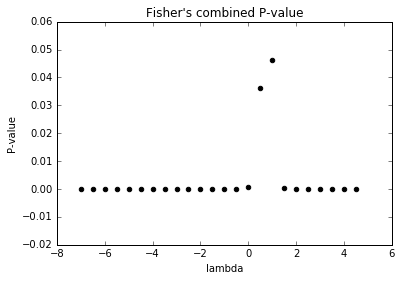

In [6]:
plt.scatter(np.arange(lambda_lower, lambda_upper+1, 0.5), fisher_pvalues, color='black')
plt.title("Fisher's combined P-value")
plt.xlabel("lambda")
plt.ylabel("P-value")
#plt.ylim(0, 0.1)
plt.show()



In [7]:
maximize_fisher_combined_pvalue(N=(N1, N2), overall_margin=margin, 
                          pvalue_funs=(cvr_pvalue, nocvr_pvalue))

{'allocation lambda': 0.8,
 'max_pvalue': 0.07049685182933918,
 'min_chisq': 8.64901486239472}

# Lower and upper bounds for the Fisher $P$-value

In the text, we derive a simple way to construct piecewise constant upper and lower bounds on the Fisher combination function. These are equivalent to upper and lower bounds on the Fisher combined $P$-value. This is helpful because we don't necessarily care what the maximum $P$-value is, as long as it is below the risk limit.

Below, we construct these bounds for values of $\lambda$ between $-3$ and $3.5$.

In [8]:
res = bound_fisher_fun(N_w1, N_l1, N1, N_w2, N_l2, N2,
                       pvalue_funs=(cvr_pvalue, nocvr_pvalue), 
                       plausible_lambda_range=(-3, 3), stepsize=0.5)
res

{'grid': array([-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,
         2.5,  3. ,  3.5]),
 'lower_bounds': [0.0,
  0.0,
  0.0,
  0.0,
  5.162537064506978e-14,
  2.9647292287826588e-08,
  6.45536420157411e-05,
  0.004463614814719463,
  0.005753100911688458,
  2.2847030396455636e-05,
  5.306866057708248e-13,
  0.0,
  0],
 'sample_points': [0.0,
  0.0,
  0.0,
  0.0,
  5.162537064506978e-14,
  2.9647292287826588e-08,
  0.0005888052510039099,
  0.036110760925335494,
  0.0463537977110563,
  0.0002190089201412615,
  5.7416293941514596e-12,
  0.0,
  0,
  0],
 'upper_bounds': [0.0,
  0.0,
  0.0,
  5.162537064506978e-14,
  2.9647292287826588e-08,
  0.0005888052510039099,
  0.24445326382258914,
  0.30586956879736105,
  0.0019893316906974823,
  6.099443172757901e-11,
  0.0,
  0,
  0]}

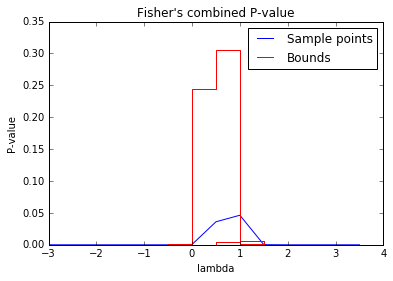

In [9]:
plt.plot(res['grid'], res['sample_points'], 'b-', label="Sample points")
lb = [0]+res['lower_bounds']
ub = [0]+res['upper_bounds']
plt.step(res['grid'], lb, 'r-', label="Bounds")
plt.step(res['grid'], ub, 'r-')
plt.xlabel("lambda")
plt.ylabel("P-value")
plt.title("Fisher's combined P-value")
plt.legend()
plt.show()

The upper bound is larger than the risk limit, but none of the sample points are. This suggests that we should refine the mesh and obtain a tighter upper bound. If this new upper bound is *still* greater than the risk limit, then we may need to escalate the audit. Otherwise, the audit can stop.

In [10]:
# Refine the mesh by decreasing the step size
res2 = bound_fisher_fun(N_w1, N_l1, N1, N_w2, N_l2, N2,
                    pvalue_funs=(cvr_pvalue, nocvr_pvalue), 
                    plausible_lambda_range=(-0.5, 2), 
                    stepsize=0.05)

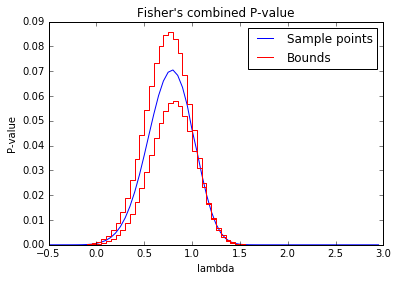

In [11]:
plt.plot(res2['grid'], res2['sample_points'], 'b-', label="Sample points")
lb = [0]+res2['lower_bounds']
ub = [0]+res2['upper_bounds']
plt.step(res2['grid'], lb, 'r-', label="Bounds")
plt.step(res2['grid'], ub, 'r-')
plt.xlabel("lambda")
plt.ylabel("P-value")
plt.title("Fisher's combined P-value")
plt.legend()
plt.show()